In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.listdir()

['__notebook__.ipynb']

In [3]:
base_dir = '/kaggle/input/breast-cancer-detection-for-implant-enabled'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/test'))

Contents of base directory:
['test', 'train']

Contents of train directory:
['0', '1']

Contents of validation directory:
['0', '1']


In [4]:

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with training 0/1 pictures
train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')

# Directory with validation 0/1 pictures
validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')


In [5]:
#file names
train_0_fnames = os.listdir( train_0_dir )
train_1_fnames = os.listdir( train_1_dir )

print(train_0_fnames[:10])
print(train_1_fnames[:10])

['9028_2027211267_e7d12f82a7d8482c88bd66d991d099ce.png', '10960_372686829_2dc2962b2fa84d47b064c2386cf6c534.png', '5880_1606772933_51bbcc6f55074d97bd9faddab8f4734d.png', '59307_1872529486_c98231ae2051429abb24e941707c8391.png', '40747_1538981207_9ac0dfce13af45b99aed82fbb8559937.png', '8570_984799738_4d8a9e1ad2584ef3bbe8339e419c1359.png', '26979_643852361_1794e30b934a4dad9cb59369be2d6cf7.png', '3668_528436173_98a817d79ef04929869f7785872f1553.png', '37862_1858219249_1874569bea774f668ab460249836f94e.png', '46199_1089598723_374d3f238a0f447e86832e2d0ee973b8.png']
['12725_1435663649_8b03827e16644347b902b96676170570.png', '18026_1303889904_19e590d62d1f4e829b1d03e6de72edbb.png', '18026_1905432390_406c745a18f44fb2b4f56e0b1980ece9.png', '12725_156027166_9a014220b25a40f3b3763adeb593798f.png', '62608_344315857_0ea67ddfe5d642a0b686958f169e2624.png', '12725_1435663649_4321e033ab3b4df28f0f1b6f614ec8df.png', '18026_927775324_691f5e6443f6450696bf914915717456.png', '18026_2091972299_39d7df4bc21a4b45b87071

In [6]:
#total number of images
print("total number of images in train's zero folder",len(os.listdir(train_0_dir)))
print("total number of images in train's one folder",len(os.listdir(train_1_dir)))

#validation 
print("total number of images in test's zero folder", len(os.listdir(validation_0_dir)))
print("total number of images in test's one folder", len(os.listdir(validation_1_dir)))

total number of images in train's zero folder 951
total number of images in train's one folder 953
total number of images in test's zero folder 238
total number of images in test's one folder 3


Sample 0 image:


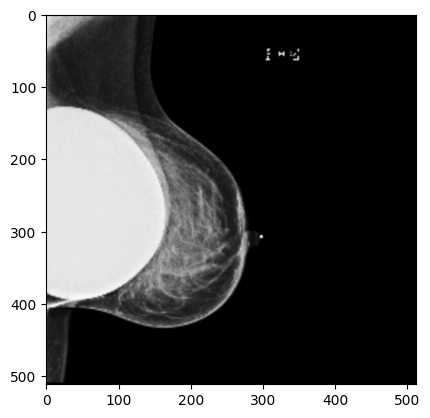


Sample 1 image:


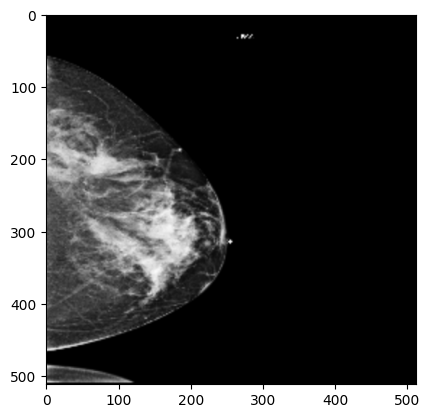

In [7]:
print("Sample 0 image:")
plt.imshow(load_img(f"{os.path.join(train_0_dir, os.listdir(train_0_dir)[0])}"))
plt.show()

print("\nSample 1 image:")
plt.imshow(load_img(f"{os.path.join(train_1_dir, os.listdir(train_1_dir)[0])}"))
plt.show()

In [8]:
#data argumentation on train data and rescale the test data
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class 
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=270,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     brightness_range=[0.5, 1],
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='binary',
                                                      target_size=(224, 224))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=16,
                                                                class_mode='binary',
                                                                target_size=(224, 224))
  ### END CODE HERE
  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR=train_dir, VALIDATION_DIR=validation_dir)

Found 1904 images belonging to 2 classes.
Found 241 images belonging to 2 classes.


In [10]:

def create_model():
  model = tf.keras.models.Sequential([ 
          tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224,224, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                loss=tf.keras.losses.binary_crossentropy,
                metrics=['accuracy']) 

  return model

In [11]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.989):
      print("\nReached 98.9% accuracy so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

In [12]:
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    verbose = 1, callbacks=[callbacks])

Epoch 1/50
119/119 [==============================] - 56s 364ms/step - loss: 0.6894 - accuracy: 0.5131 - val_loss: 0.6257 - val_accuracy: 0.7012
Epoch 2/50
119/119 [==============================] - 37s 308ms/step - loss: 0.6793 - accuracy: 0.5546 - val_loss: 0.6210 - val_accuracy: 0.5643
Epoch 3/50
119/119 [==============================] - 37s 312ms/step - loss: 0.6721 - accuracy: 0.5588 - val_loss: 0.6236 - val_accuracy: 0.4813
Epoch 4/50
119/119 [==============================] - 36s 302ms/step - loss: 0.6569 - accuracy: 0.5877 - val_loss: 0.5941 - val_accuracy: 0.4606
Epoch 5/50
119/119 [==============================] - 36s 305ms/step - loss: 0.6399 - accuracy: 0.5909 - val_loss: 0.7606 - val_accuracy: 0.2780
Epoch 6/50
119/119 [==============================] - 36s 303ms/step - loss: 0.6339 - accuracy: 0.6103 - val_loss: 0.5914 - val_accuracy: 0.5602
Epoch 7/50
119/119 [==============================] - 37s 307ms/step - loss: 0.6213 - accuracy: 0.6308 - val_loss: 0.6996 - val_ac

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

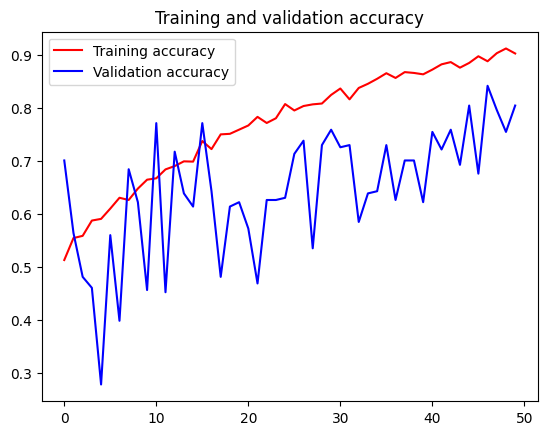

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [15]:
model.save("cancer.h5")

### Transfer learning

In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


To check that all the layers in the model were set to be non-trainable, you can also run the cell below:

In [17]:
from tensorflow.keras.models import Model

In [18]:
# Load the ResNet-50 base model without top classification layers
base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.15
x = tf.keras.layers.Dropout(0.15)(x)

# Add another fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation="relu")(x)

# Add another dropout layer
x = tf.keras.layers.Dropout(0.15)(x)

# Add a final sigmoid layer for binary classification
x = Dense(1, activation='sigmoid')(x)

# Create the complete model by using the Model class
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

87910968/87910968 [==============================] - 0s 0us/step


In [19]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100
119/119 [==============================] - 79s 373ms/step - loss: 0.6831 - accuracy: 0.7621 - val_loss: 0.0474 - val_accuracy: 0.9793
Epoch 2/100
119/119 [==============================] - 43s 358ms/step - loss: 0.2136 - accuracy: 0.9217 - val_loss: 0.0978 - val_accuracy: 0.9668
Epoch 3/100
119/119 [==============================] - 41s 346ms/step - loss: 0.1782 - accuracy: 0.9359 - val_loss: 0.7071 - val_accuracy: 0.9170
Epoch 4/100
119/119 [==============================] - 41s 345ms/step - loss: 0.1352 - accuracy: 0.9611 - val_loss: 0.0388 - val_accuracy: 0.9959
Epoch 5/100
119/119 [==============================] - 42s 351ms/step - loss: 0.1326 - accuracy: 0.9669 - val_loss: 0.1609 - val_accuracy: 0.9668
Epoch 6/100
119/119 [==============================] - 42s 353ms/step - loss: 0.0839 - accuracy: 0.9748 - val_loss: 0.0086 - val_accuracy: 0.9959
Epoch 7/100
119/119 [==============================] - 42s 347ms/step - loss: 0.0643 - accuracy: 0.9806 - val_loss: 0.1714 -

In [20]:
model.save("Cancer2.h5")

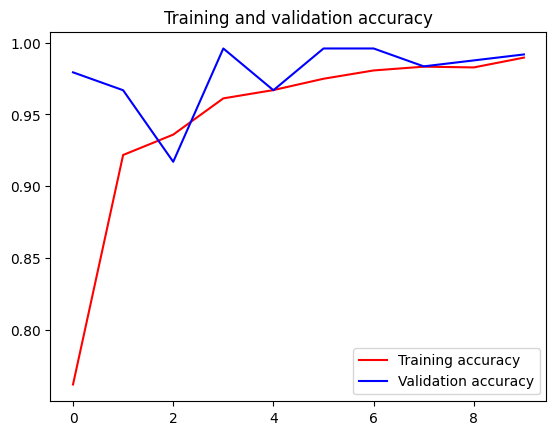

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_5[0][0]']               
 alization)                     )                                                             

In [23]:
keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [24]:
"""import tensorflow as tf
from tensorflow import keras

# Load the model from the H5 file
model = keras.models.load_model('Cancer2.h5')

# Display the model summary 
model.summary()


"""

"import tensorflow as tf\nfrom tensorflow import keras\n\n# Load the model from the H5 file\nmodel = keras.models.load_model('Cancer2.h5')\n\n# Display the model summary \nmodel.summary()\n\n\n"

In [25]:
y_pred_prob = model.predict_generator(validation_generator, steps=len(validation_generator))


/tmp/ipykernel_22/2257492193.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(validation_generator, steps=len(validation_generator))


In [26]:
y_pred_prob

array([[2.09092512e-03],
       [0.00000000e+00],
       [4.86797047e-09],
       [0.00000000e+00],
       [5.40312153e-16],
       [1.29831715e-10],
       [4.83636740e-08],
       [4.03563672e-06],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.00401894e-05],
       [2.02954983e-21],
       [0.00000000e+00],
       [3.45795372e-11],
       [5.97387779e-21],
       [2.46557974e-09],
       [5.21716988e-03],
       [8.69930421e-21],
       [1.57631314e-13],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.03531461e-09],
       [6.25698698e-14],
       [6.49832218e-05],
       [0.00000000e+00],
       [8.29115957e-20],
       [5.29688598e-13],
       [1.95210230e-08],
       [1.88659247e-32],
       [0.00000000e+00],
       [9.66078587e-05],
       [3.43869630e-37],
       [3.09707730e-07],
       [1.60267543e-33],
       [2.98025773e-24],
       [1.48699612e-17],
       [8.37910683e-35],
       [0.00000000e+00],
       [7.26609051e-24],
       [9.20666673e-04],


In [27]:
threshold = 0.5
y_pred1 = (y_pred_prob > threshold).astype(int)


In [28]:
y_pred1

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [29]:
lab=validation_generator.labels
lab

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
      dtype=int32)

In [30]:
from sklearn.metrics import accuracy_score,classification_report, jaccard_score

In [31]:
jaccard_score(y_true=lab,y_pred=y_pred1, pos_label=0)

0.966804979253112

In [32]:
accuracy_score(y_true=lab,y_pred=y_pred1)

0.966804979253112

In [33]:
print(classification_report(lab,y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       238
           1       0.00      0.00      0.00         3

    accuracy                           0.97       241
   macro avg       0.49      0.49      0.49       241
weighted avg       0.97      0.97      0.97       241



In [34]:
"""# Load the model from the H5 file
model2 = keras.models.load_model('Cancer.h5')

# Display the model summary 
model2.summary()
"""

"# Load the model from the H5 file\nmodel2 = keras.models.load_model('Cancer.h5')\n\n# Display the model summary \nmodel2.summary()\n"

In [35]:
y_pred_prob2 = model.predict_generator(validation_generator, steps=len(validation_generator))


/tmp/ipykernel_22/3340534290.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob2 = model.predict_generator(validation_generator, steps=len(validation_generator))


In [36]:
y_pred2 = (y_pred_prob2 > threshold).astype(int)

In [37]:
y_pred2

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [38]:
jaccard_score(lab,y_pred2,  pos_label=0)

0.966804979253112

In [39]:
accuracy_score(lab,y_pred2)

0.966804979253112

In [40]:
print(classification_report(lab,y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       238
           1       0.00      0.00      0.00         3

    accuracy                           0.97       241
   macro avg       0.49      0.49      0.49       241
weighted avg       0.97      0.97      0.97       241



**EfficientNetV2S**

In [41]:
from tensorflow.keras.applications import EfficientNetV2S

In [42]:
# Load the ResNet-50 base model without top classification layers
base_model = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.15
x = tf.keras.layers.Dropout(0.1)(x)

# Add another fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation="relu")(x)

# Add another dropout layer
x = tf.keras.layers.Dropout(0.1)(x)
# Add another fully connected layer with 256 hidden units and ReLU activation
x = Dense(256, activation="relu")(x)
# Add a final sigmoid layer for binary classification
x = Dense(1, activation='sigmoid')(x)

# Create the complete model by using the Model class
model_1 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

82420632/82420632 [==============================] - 1s 0us/step


In [43]:
history = model_1.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    batch_size=16,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100


2023-09-26 22:09:33.328924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 [==============================] - 131s 445ms/step - loss: 0.5663 - accuracy: 0.7101 - val_loss: 0.1865 - val_accuracy: 0.8921
Epoch 2/100
119/119 [==============================] - 48s 405ms/step - loss: 0.2673 - accuracy: 0.8902 - val_loss: 0.0593 - val_accuracy: 0.9751
Epoch 3/100
119/119 [==============================] - 49s 412ms/step - loss: 0.1725 - accuracy: 0.9386 - val_loss: 0.0626 - val_accuracy: 0.9959
Epoch 4/100
119/119 [==============================] - 49s 408ms/step - loss: 0.1296 - accuracy: 0.9506 - val_loss: 0.1147 - val_accuracy: 0.9544
Epoch 5/100
119/119 [==============================] - 49s 409ms/step - loss: 0.0644 - accuracy: 0.9727 - val_loss: 0.0161 - val_accuracy: 0.9959
Epoch 6/100
119/119 [==============================] - 49s 406ms/step - loss: 0.0833 - accuracy: 0.9774 - val_loss: 0.0205 - val_accuracy: 0.9959
Epoch 7/100
119/119 [==============================] - 50s 415ms/step - loss: 0.0563 - accuracy: 0.9800 - val_loss: 0.0149 - val_accura

In [44]:
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

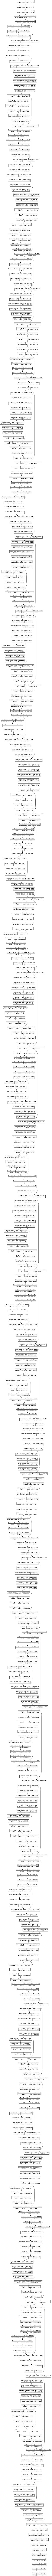

In [45]:
keras.utils.plot_model(model_1, show_layer_names=True, show_shapes=True)

In [46]:
y_pred_prob_1 = model.predict_generator(validation_generator, steps=len(validation_generator))


/tmp/ipykernel_22/341806347.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob_1 = model.predict_generator(validation_generator, steps=len(validation_generator))


In [47]:
y_pred_1 = (y_pred_prob_1 > threshold).astype(int)

In [48]:
jaccard_score(lab,y_pred_1,  pos_label=0)

0.966804979253112

In [49]:
print(classification_report(lab, y_pred_1))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       238
           1       0.00      0.00      0.00         3

    accuracy                           0.97       241
   macro avg       0.49      0.49      0.49       241
weighted avg       0.97      0.97      0.97       241



In [50]:
model_1.save("el_cancer.h5")